## How are the vols scores affected by the weather at Neyland?

<u>**Overall prompt: Make a chart showing how the temperature relates to the vols score.**</u>

Ideally your python code gathers all the data, but not a requirement if you hit a big blocker.

Use 1-4 below as guiding prompts.

In [11]:
# Any needed libraries here
import requests

import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

#### 1. Find/gather data on Vols football attendance for 2022 and 2023 season (this and last season)
  * We need fields for date, time (optional but ideal), and vols score
    * We only want home games in the chart; either filter or flag home games
  * I used `pd.read_html()` and wikipedia
    * eg 2023's page: https://en.wikipedia.org/wiki/2023_Tennessee_Volunteers_football_team

In [2]:
# I'd suggest to use this cell to gather/clean data to make
# a dataframe to accomplish your tasks
def wiki_vols_season_df(year=2023):
    url = f"https://en.wikipedia.org/wiki/{year}_Tennessee_Volunteers_football_team"
    tables = pd.read_html(url)
    games_dfs = [table for table in tables if "Attendance" in table]
    games_df = games_dfs[0]

    games_df["Year"] = year

    return games_df[:-1]

In [3]:
# Get and combine data
vols_22 = wiki_vols_season_df(2022)
vols_23 = wiki_vols_season_df(2023)
vols = pd.concat((vols_22, vols_23)).reset_index(drop=True)

# Remove tooltip (better ways to clean but this is easy)
vols["Date"] = vols["Date"].str.split("}").str[-1]

# Mark rows that have neyland as site as home games
vols["Home"] = vols["Site"].str.contains("Neyland")

# Create datetime field
vols["Datetime"] = vols["Date"] + ", " + vols["Year"].astype(str) + " " + vols["Time"]
vols["Datetime"] = pd.to_datetime(vols["Datetime"], utc=False)

# Pull vols score from result
vols[["WinLoss", "VolsScore", "OppScore"]] = vols["Result"].str.extract(
    r"([WL]) (\d+)–(\d+)"
)

# Subset columns
vols = vols[["Datetime", "Home", "WinLoss", "VolsScore", "OppScore"]]

# Filter out games that haven't happened yet
vols = vols.dropna()

vols["VolsScore"] = vols["VolsScore"].astype(float)
vols["OppScore"] = vols["OppScore"].astype(float)

# Only home games
vols_home = vols[vols["Home"]]
vols_home = vols_home.drop(columns=["Home"])
vols_home = vols_home.reset_index(drop=True)

vols_home.head()

/var/folders/2h/lk98psvs47d7pf2j4k9rq2mm0000gn/T/ipykernel_90529/1539464207.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vols["Datetime"] = pd.to_datetime(vols["Datetime"], utc=False)


,Datetime,WinLoss,VolsScore,OppScore
0,2022-09-01 19:00:00,W,59.0,10.0
1,2022-09-17 19:00:00,W,63.0,6.0
2,2022-09-24 15:30:00,W,38.0,33.0
3,2022-10-15 15:30:00,W,52.0,49.0
4,2022-10-22 12:00:00,W,65.0,24.0


#### 2. Find/gather historical weather data with a web API
  * I used `requests.get()` and https://open-meteo.com/ but you can use other things

In [4]:
# gratis
NEYLAND_LAT = "35.95"
NEYLAND_LON = "-83.92"

Some API wrapper functions geared towards my processes.

In [5]:
def hourly_temps(lat, lon, start_date, end_date):
    base_url = "https://archive-api.open-meteo.com/v1"
    end_point = "/archive"

    params = {
        "hourly": "temperature_2m",
        "temperature_unit": "fahrenheit",
    }

    params["latitude"] = lat
    params["longitude"] = lon
    params["start_date"] = start_date
    params["end_date"] = end_date

    response = requests.get(base_url + end_point, params=params)
    response.raise_for_status()

    data = response.json()
    df = pd.DataFrame(data["hourly"])

    df.columns = ["Datetime", "TempF"]
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    return df


def hourly_temps_day(lat, lon, date):
    return hourly_temps(lat, lon, date, date)


def hourly_temps_day_neyland(date):
    return hourly_temps_day(NEYLAND_LAT, NEYLAND_LON, date)

### Method 1

Specifically asking for each date via loop.

* Pros: only asking for relevant records\* and might be easier to customize (ie I added high and low temp for the day)
* Cons: many API calls and more code

\*depending on your API's rate limiting this might be desirable

In [6]:
records = []
for dt in tqdm(vols_home["Datetime"]):
    date = dt.strftime("%Y-%m-%d")

    temps = hourly_temps_day_neyland(date)

    closest_to_kickoff_i = (temps["Datetime"] - dt).abs().idxmin()
    kickoff_temp = temps.loc[closest_to_kickoff_i, "TempF"]

    record = {
        "TempF": kickoff_temp,
        "DayLowTempF": temps["TempF"].min(),
        "DayHiTempF": temps["TempF"].max(),
    }

    records.append(record)

game_temps = pd.DataFrame(records)
vols_home_temps = pd.concat((vols_home, game_temps), axis=1)

vols_home_temps.head()

  0%|          | 0/12 [00:00<?, ?it/s]

,Datetime,WinLoss,VolsScore,OppScore,TempF,DayLowTempF,DayHiTempF
0,2022-09-01 19:00:00,W,59.0,10.0,88.8,62.8,89.3
1,2022-09-17 19:00:00,W,63.0,6.0,84.4,62.0,84.4
2,2022-09-24 15:30:00,W,38.0,33.0,68.4,55.5,78.3
3,2022-10-15 15:30:00,W,52.0,49.0,68.3,53.6,77.3
4,2022-10-22 12:00:00,W,65.0,24.0,40.4,40.4,73.0


### Method 2

Ask for whole date range and use a fancy join.

* Pros: lower code and only one API call\*
* Cons: asks for so much superfluous data (might not scale)

\*depending on your API's rate limiting this might be desirable

In [7]:
all_date_strs = vols_home["Datetime"].dt.strftime("%Y-%m-%d")

min_date = min(vols_home["Datetime"]).strftime("%Y-%m-%d")
max_date = max(vols_home["Datetime"]).strftime("%Y-%m-%d")

temps = hourly_temps(
    lat=NEYLAND_LAT,
    lon=NEYLAND_LON,
    start_date=min_date,
    end_date=max_date,
)

vols_home_temps = pd.merge_asof(vols_home, temps, on="Datetime")

vols_home_temps.head()

,Datetime,WinLoss,VolsScore,OppScore,TempF
0,2022-09-01 19:00:00,W,59.0,10.0,88.8
1,2022-09-17 19:00:00,W,63.0,6.0,84.4
2,2022-09-24 15:30:00,W,38.0,33.0,68.4
3,2022-10-15 15:30:00,W,52.0,49.0,68.3
4,2022-10-22 12:00:00,W,65.0,24.0,40.4


#### 3. How do the scores and temps relate?

  * Calculate a correlation coefficient for temp vs score
  * Make a plot of the temp vs score
    * If you're feeling fancy; add the cor value to the plot title or other plot place

In [8]:
vols_home_temps["VolsScore"].corr(vols_home_temps["TempF"])

-0.3768973220743457

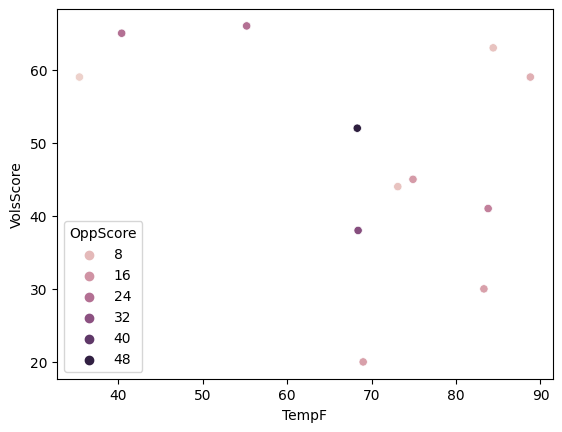

In [13]:
sns.scatterplot(data=vols_home_temps, x="TempF", y="VolsScore", hue="OppScore")
plt.show()

In [10]:
fig = px.scatter(
    vols_home_temps,
    x="TempF",
    y="VolsScore",
    color="OppScore",
    trendline="ols",
)
fig.show()

results = px.get_trendline_results(fig)
results.iloc[0, 0].summary()

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.656
Date:                Thu, 09 Nov 2023   Prob (F-statistic):              0.227
Time:                        11:43:20   Log-Likelihood:                -47.835
No. Observations:                  12   AIC:                             99.67
Df Residuals:                      10   BIC:                             100.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.6786     17.722      3.988      0.003      31.192     110.165
x1            -0.3226      0.251     -1.287      0.227      -0.881       0.236
==============================================================================
Omnibus:                        0.971   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                0.417
Skew:                          -0.444   Prob(JB):                        0.812
Kurtosis:                       2.784   Cond. No.                         304.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 4. Interpret the chart from 3

Correlation hints at a negative relationship.  Simple linear regression shows no siginificant relationship ($p \approx 0.23$ & $R^2 \approx 0.14$)

The scatter plot shows that the negative relationship is largely due to 3 high leverage outliers (w/higher points & lower temps).

There's not enough evidence to claim the Vols are better in hot or cold weather... yet...